# Simplified NASNet

Our goal is to build a simplified NASNet and employ it to design normal and reduction cells for a CIFAR-10 classification network. We have *six* primitive operations in the search space:
* 3x3 Depthwise Separable Convolution
* 5x5 Depthwise Separable Convolution
* 7x7 Depthwise Separable Convolution
* 3x3 Average Pool
* 3x3 Max Pool
* Identity

The combination operations are identical to NASNet namely add and concat. The network is composed of single layer cells such that each cell block just chooses from the cell inputs. NASNet, in contrast, allows the cell blocks to choose from the outputs of the previous blocks in the cell which allows the formation of multiple layers in the cell. In this project, we use the NASCell as a recurrent unit. The choice of the recurrent cell is arbitrary.

We train the RNN for 150 episodes. Each episode involves three distinct steps. In the first step, the RNN predicts architectures for normal and reduction cells. To balance the exploration and exploitation aspects of the search, we sample random cell architectures with probability *p*. The second step involves training the child network and obtaining a reward. The reward is a measure of improvement over the previous performances. It is computed as the difference of the accuracy of the child network in the current episode and the past accuracies. The past accuracies are represented by a moving average with a fixed window size. The third and final step is to train the RNN with the cell architectures and their reward signals.

#### Installation

The *tensorflow-addons* package contains an implementation of NASCell.

In [1]:
%%capture
!pip install tensorflow-addons

####  Module Import

In [2]:
%%capture
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import pandas as pd

from tensorflow.keras import layers, optimizers
from collections import deque
from matplotlib.ticker import MaxNLocator
from math import pow

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#### Dataset download and initialization

In [3]:
DATASET_PARAMS = dict(
    input_shape=(32, 32, 3),
    n_classes=10,
    baseline_accuracy=.1,
)

train_ds, val_ds = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[20%:]'],
    as_supervised=True
)

2022-10-15 01:19:59.470023: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

2022-10-15 01:20:07.049279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 01:20:07.150910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 01:20:07.151737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 01:20:07.153839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Architecture Search

In [4]:
CHILD_PARAMS = dict(
    epochs=6,
    batch_size=128,
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    rolling_accuracies_window=20,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]

class CNNCell():
    """
    It composes a cell based on the input configuration.
    Arguments:
        stride: A positive integer to represent the convolution strides.
            Normal cells use stride=1 and reduction cells use stride=2
    """
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
    """
    This method sends the input through a convolution layer with
    a fixed channel size to ensure that the inputs to each cell block
    have identical channel dimensions.
    """
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
    """
    It transforms the input branches to an identical feature space.
    It is useful when a cell receives inputs with different feature spaces.
    """
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
    """
    It halves the input feature space using a convolution layer with stride 2
    """
        if self.stride == 2:
            inputs = list(
                map(
                    lambda inp: layers.Conv2D(
                        self.channels,
                        3,
                        strides=(2,2),
                        padding='same'
                    )(inp),
                    inputs
                )
            )
        
        return inputs
    
    def apply_op(self, op_id, inp):
    """
    It applies a primitive operation to the input.
    """
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
    """
    It applies a combination operation to the inputs.
    """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
    """
    It constructs a cell based on the cell_config and the branches.
    A cell_config is 2-D numpy array of shape [5,5] which contains
    the 5 state choices for each of the 5 blocks.
    """
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class ChildManager():
    def __init__(self):
        self.tds = CHILD_PARAMS['train_ds'].shuffle(
            500,
            reshuffle_each_iteration=True
        ).batch(CHILD_PARAMS['batch_size'])
        self.vds = CHILD_PARAMS['val_ds'].batch(256)

        self.past_accuracies = deque(
            maxlen=CHILD_PARAMS['rolling_accuracies_window']
        )
        self.past_accuracies.append(DATASET_PARAMS['baseline_accuracy'])

        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]

    def make_child(self, config):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        model.summary()

        return model
    
    def train(self, model):
        history = model.fit(
            self.tds,
            validation_data=self.vds,
            epochs=CHILD_PARAMS['epochs']
        )
        accuracy = max(history.history['val_accuracy'])

        return accuracy
    
    def get_rewards(self, config):
        model = self.make_child(config)
        accuracy = self.train(model)

        self.past_accuracies.append(accuracy)
        rolling_accuracy = (sum(self.past_accuracies)/len(self.past_accuracies))
        reward = accuracy - rolling_accuracy

        return reward, accuracy

CONTROLLER_PARAMS = dict(
    exploration=0.5,
    hidden_size=32,
    episodes=150,
    learning_rate=0.001,
)

BLOCK_TIMESTEPS = 5
CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self):
        self.rnn = self.make_rnn()
        self.store = dict(children=[], rewards=[], accuracies=[])
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.optimizer = optimizers.Adam(
            learning_rate=CONTROLLER_PARAMS['learning_rate']
        )

    def make_rnn(self):
        start_state = tf.keras.Input(shape=(), dtype=tf.int32)
        rnn_cell = tfa.rnn.NASCell(CONTROLLER_PARAMS['hidden_size'])

        initial_data = {
            'cell_state': [
                tf.zeros((1, CONTROLLER_PARAMS['hidden_size']), dtype=tf.float32),
                tf.zeros((1, CONTROLLER_PARAMS['hidden_size']), dtype=tf.float32)
            ],
            'embeddings': tf.keras.layers.Embedding(
                len(STATE_SPACE[0]['values']),
                CONTROLLER_PARAMS['hidden_size']
            )
        }

        prev_output = initial_data['embeddings'](start_state)
        prev_cell_state = initial_data['cell_state']
        predictions = []

        print('Controller Timesteps: ', TOTAL_TIMESTEPS)

        for timestep, (cell, block, state) in enumerate(STATE_ADDRESSES):
            prev_output, prev_cell_state = rnn_cell(prev_output, prev_cell_state)

            prediction_layer = tf.keras.layers.Dense(
                len(STATE_SPACE[state]['values']),
                activation='softmax',
                name='softmax_%d'%timestep
            )
            pred_action = prediction_layer(prev_output)
            predictions.append(pred_action)
        
        model = tf.keras.Model(inputs=start_state, outputs=predictions)
        model.summary()

        return model
    
    def predict_child(self, start_state):
        if np.random.random() < CONTROLLER_PARAMS['exploration']:
            def sample_state_space(x):
                (_, __, state_id) = x
                return random.randrange(len(STATE_SPACE[state_id]['values']))
    
            predictions = list(map(
                sample_state_space,
                STATE_ADDRESSES
            ))
            print(
                'Random Predictions:',
                np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)
            )
        else:
            predictions = self.rnn([start_state])
            predictions = list(map(lambda x: np.argmax(x), predictions))

            print(
                'RNN Predictions:',
                np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)
            )

        return predictions
    
    def save_trial(self, child, reward, accuracy):
        self.store['children'].append(child)
        self.store['rewards'].append(reward)
        self.store['accuracies'].append(accuracy)
    
    def train_step(self):
        child_config = self.store['children'][-1]
        reward = self.store['rewards'][-1]
        start_state = np.array([child_config[0]])

        with tf.GradientTape() as tape:
            outputs = controller.rnn(start_state)
            loss = 0.

            for index, output in enumerate(outputs):
                y_true = [child_config[index]]
                loss += self.loss_fn(y_true, output)
            
            grads = tape.gradient(loss, controller.rnn.trainable_variables)
            
            for index, grad in enumerate(grads):
                grads[index] = tf.multiply(grad, reward)

            self.optimizer.apply_gradients(
                zip(grads, controller.rnn.trainable_variables)
            )

controller = Controller()
child_manager = ChildManager()
start_state = np.array([random.randrange(len(STATE_SPACE[0]))])

for episode in range(CONTROLLER_PARAMS['episodes']):
    predictions = controller.predict_child(start_state)
    
    config = np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)

    # Evaluate the child generated by the controller
    reward, accuracy = child_manager.get_rewards(config)
    print(
        'Episode: {} Reward: {} Accuracy: {}'.format(
            episode,
            reward,
            accuracy
        )
    )

    # Store predicted child and its rewards
    controller.save_trial(predictions, reward, accuracy)
    
    # Train the Controller
    controller.train_step()

    # Update start_state for next episode.
    start_state = np.array([predictions[0]])
    tf.print('Start State:', start_state)

Controller Timesteps:  50
RNN Predictions: [[[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
Episode: 0 Child Config: [[[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (

2022-10-15 01:21:11.425340: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-15 01:21:12.937709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 32s 77ms/step - loss: 2.0827 - accuracy: 0.2257 - val_loss: 2.0309 - val_accuracy: 0.2443


Epoch 2/6
313/313 [==============================] - 8s 25ms/step - loss: 1.9475 - accuracy: 0.3015 - val_loss: 1.9146 - val_accuracy: 0.3184
Epoch 3/6
313/313 [==============================] - 7s 24ms/step - loss: 1.9000 - accuracy: 0.3279 - val_loss: 1.8804 - val_accuracy: 0.3402
Epoch 4/6
313/313 [==============================] - 7s 23ms/step - loss: 1.8770 - accuracy: 0.3377 - val_loss: 1.8781 - val_accuracy: 0.3379
Epoch 5/6
313/313 [==============================] - 7s 23ms/step - loss: 1.8605 - accuracy: 0.3471 - val_loss: 1.8521 - val_accuracy: 0.3444
Epoch 6/6
313/313 [==============================] - 7s 23ms/step - loss: 1.8438 - accuracy: 0.3541 - val_loss: 1.8343 - val_accuracy: 0.3601
Episode: 0 Reward: 0.13005000054836274 Accuracy: 0.36010000109672546
Start State: array([0])
Random Predictions: [[[0 0 5 3 0]
  [0 1 3 3 1]
  [1 0 5 5 1]
  [1 0 2 5 0]
  [1 1 0 3 0]]

 [[1 0 2 3 0]
  [1 0 4 0 0]
  [1 1 5 3 1]
  [1 0 5 5 0]
  [0 0 3 5 1]]]
Episode: 1 Child Config: [[[0 0 5

## Training Metrics

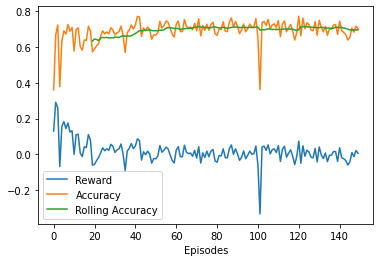

In [5]:
accuracies_df = pd.DataFrame(controller.store['accuracies'])
rolling_accuracies = accuracies_df.rolling(CHILD_PARAMS['rolling_accuracies_window']).mean()[0].tolist()

plt.plot(controller.store['rewards'], label='Reward')
plt.plot(controller.store['accuracies'], label='Accuracy')
plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Episodes')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

## Performance Analysis

In [6]:
child_configs = controller.store['children']
df = pd.DataFrame(child_configs)
df['Accuracy'] = controller.store['accuracies']
df.index.name = 'Episodes'
df.columns.name = 'Timesteps'

df.to_csv('nasnet_stats.csv')

def column_summary(df, column):
    column_df = df[[column, 'Accuracy']].groupby(column)
    column_stats = column_df.mean()
    column_stats['Counts'] = column_df.count()
    return column_stats

display(df)
for layer_id in range(TOTAL_TIMESTEPS):
    display(column_summary(df, layer_id))

Timesteps  0  1  2  3  4  5  6  7  8  9  ...  41  42  43  44  45  46  47  48  \
Episodes                                 ...                                   
0          0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
1          0  0  5  3  0  0  1  3  3  1  ...   0   5   5   0   0   0   3   5   
2          0  1  5  1  1  0  0  4  4  1  ...   0   3   1   0   0   1   3   2   
3          0  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   0   0   0   0   
4          0  0  1  3  0  0  0  4  2  1  ...   0   0   2   0   0   1   1   5   
...       .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
145        0  1  3  1  1  0  1  4  0  0  ...   0   2   0   0   1   1   0   5   
146        0  0  0  3  0  0  1  3  4  1  ...   0   0   1   0   0   0   1   4   
147        0  1  5  5  0  0  1  5  0  1  ...   1   0   2   1   1   1   0   2   
148        0  0  0  3  0  0  1  3  4  1  ...   0   0   1   0   0   0   1   4   
149        1  0  5  1  1  1  0  1  4  1  ...   1   4   0   1   0   0   0   2   

Timesteps  49  Accuracy  
Episodes                 
0           0  0.360100  
1           1  0.666075  
2           0  0.721775  
3           0  0.377250  
4           1  0.631175  
...        ..       ...  
145         1  0.652350  
146         0  0.704925  
147         1  0.682000  
148         0  0.715075  
149         1  0.701325  

[150 rows x 51 columns]

Timesteps  Accuracy  Counts
0                          
0          0.690630     110
1          0.684596      40

Timesteps  Accuracy  Counts
1                          
0          0.688958     105
1          0.689169      45

Timesteps  Accuracy  Counts
2                          
0          0.701004      75
1          0.678975      10
2          0.692882      18
3          0.678643      11
4          0.722753       9
5          0.649868      27

Timesteps  Accuracy  Counts
3                          
0          0.655022      20
1          0.702552      14
2          0.698386       9
3          0.696804      81
4          0.699666      14
5          0.657923      12

Timesteps  Accuracy  Counts
4                          
0          0.687862     110
1          0.692209      40

Timesteps  Accuracy  Counts
5                          
0          0.686046     111
1          0.697490      39

Timesteps  Accuracy  Counts
6                          
0          0.663227      43
1          0.699387     107

Timesteps  Accuracy  Counts
7                          
0          0.642112      19
1          0.691270      14
2          0.697022       9
3          0.713503      62
4          0.661722      32
5          0.699271      14

Timesteps  Accuracy  Counts
8                          
0          0.635628      18
1          0.712192      10
2          0.684213      13
3          0.660532      25
4          0.708734      73
5          0.694939      11

Timesteps  Accuracy  Counts
9                          
0          0.677351      41
1          0.693411     109

Timesteps  Accuracy  Counts
10                         
0          0.681249      38
1          0.691658     112

Timesteps  Accuracy  Counts
11                         
0          0.691877     107
1          0.681916      43

Timesteps  Accuracy  Counts
12                         
0          0.704757      63
1          0.707746      12
2          0.685904      13
3          0.689241      14
4          0.703206      12
5          0.651554      36

Timesteps  Accuracy  Counts
13                         
0          0.595661       7
1          0.663270      11
2          0.716252      11
3          0.676490      18
4          0.695174      24
5          0.698074      79

Timesteps  Accuracy  Counts
14                         
0          0.652872      31
1          0.698438     119

Timesteps  Accuracy  Counts
15                         
0          0.667300      50
1          0.699882     100

Timesteps  Accuracy  Counts
16                         
0          0.689443     118
1          0.687468      32

Timesteps  Accuracy  Counts
17                         
0          0.618696      12
1          0.689638      13
2          0.675994      22
3          0.684583      16
4          0.706172      76
5          0.679025      11

Timesteps  Accuracy  Counts
18                         
0          0.622143      14
1          0.706021      12
2          0.690810      15
3          0.682328      16
4          0.694218      11
5          0.698234      82

Timesteps  Accuracy  Counts
19                         
0          0.692910      93
1          0.682677      57

Timesteps  Accuracy  Counts
20                         
0          0.695578     105
1          0.673722      45

Timesteps  Accuracy  Counts
21                         
0          0.663872      40
1          0.698166     110

Timesteps  Accuracy  Counts
22                         
0          0.643740      34
1          0.701886      16
2          0.681686      11
3          0.710187      59
4          0.697354      20
5          0.688923      10

Timesteps  Accuracy  Counts
23                         
0          0.627131      27
1          0.683295      11
2          0.699247       8
3          0.701739      16
4          0.697517      19
5          0.707678      69

Timesteps  Accuracy  Counts
24                         
0          0.671160      47
1          0.697172     103

Timesteps  Accuracy  Counts
25                         
0          0.691980     111
1          0.680601      39

Timesteps  Accuracy  Counts
26                         
0          0.688214     108
1          0.691096      42

Timesteps  Accuracy  Counts
27                         
0          0.660393      17
1          0.693483      16
2          0.707363      68
3          0.662177      24
4          0.690295      16
5          0.665906       9

Timesteps  Accuracy  Counts
28                         
0          0.628960      12
1          0.698598      11
2          0.670985      24
3          0.680135      17
4          0.705821      14
5          0.702412      72

Timesteps  Accuracy  Counts
29                         
0          0.692537     107
1          0.680273      43

Timesteps  Accuracy  Counts
30                         
0          0.675793      38
1          0.693509     112

Timesteps  Accuracy  Counts
31                         
0          0.689775     114
1          0.686635      36

Timesteps  Accuracy  Counts
32                         
0          0.628789      24
1          0.677528       9
2          0.696148      15
3          0.678930      11
4          0.711420      77
5          0.676764      14

Timesteps  Accuracy  Counts
33                         
0          0.687445      81
1          0.690069       8
2          0.699793      19
3          0.670375      12
4          0.695412      20
5          0.690080      10

Timesteps  Accuracy  Counts
34                         
0          0.687203     110
1          0.694022      40

Timesteps  Accuracy  Counts
35                         
0          0.683320      38
1          0.690956     112

Timesteps  Accuracy  Counts
36                         
0          0.689334     108
1          0.688218      42

Timesteps  Accuracy  Counts
37                         
0          0.636499      18
1          0.706468      14
2          0.706967       6
3          0.687925      13
4          0.699967      19
5          0.694018      80

Timesteps  Accuracy  Counts
38                         
0          0.632290      24
1          0.693612      12
2          0.707341      16
3          0.671508      33
4          0.718342      54
5          0.689748      11

Timesteps  Accuracy  Counts
39                         
0          0.676477      29
1          0.692028     121

Timesteps  Accuracy  Counts
40                         
0          0.687633      46
1          0.689636     104

Timesteps  Accuracy  Counts
41                         
0          0.690810     108
1          0.684421      42

Timesteps  Accuracy  Counts
42                         
0          0.691712      76
1          0.710373      12
2          0.689827      14
3          0.684925      14
4          0.709948      11
5          0.660987      23

Timesteps  Accuracy  Counts
43                         
0          0.613540      10
1          0.711835      66
2          0.698505      19
3          0.676114      19
4          0.699327      12
5          0.655291      24

Timesteps  Accuracy  Counts
44                         
0          0.687428     110
1          0.693403      40

Timesteps  Accuracy  Counts
45                         
0          0.692521     104
1          0.681109      46

Timesteps  Accuracy  Counts
46                         
0          0.691456     102
1          0.683848      48

Timesteps  Accuracy  Counts
47                         
0          0.651581      16
1          0.717140      62
2          0.681666       8
3          0.653986      37
4          0.696130      14
5          0.697585      13

Timesteps  Accuracy  Counts
48                         
0          0.649432      14
1          0.626391       8
2          0.697406      12
3          0.686131      13
4          0.719255      58
5          0.672103      45

Timesteps  Accuracy  Counts
49                         
0          0.691729     103
1          0.683088      47